In [1]:
import base64, json, os
from io import BytesIO
from random import random
import numpy as np
import torch
import cv2
import matplotlib.pyplot as plt
np.set_printoptions(precision=4)

In [2]:
gold_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255),]

In [3]:
def get_font_info(img_size):
    font = cv2.FONT_HERSHEY_SIMPLEX  # default font
    ref = (img_size[0] + img_size[1]) / 2
    font_scale = ref / 1000
    font_thickness = int(max(ref / 400, 1))
    return font, font_scale, font_thickness


def get_random_colors(labels):
    label_set = set(labels)
    label_counts = [(l, labels.count(l)) for l in label_set]
    label_counts = sorted(label_counts, key=lambda x: -x[1])
    label2color = {}
    # the most frequeny classes will get the gold colors
    gold_colors = [(255, 0, 0), (0, 255, 0), (0, 0, 255), (0, 255, 255)]
    for i, lab in enumerate(label_counts):
        if i < len(gold_colors):
            label2color[lab[0]] = gold_colors[i]
        else:
            label2color[lab[0]] = (random() * 255, random() * 255, 
                                   random() * 255)
    return label2color


def put_text(im, text, bottomleft=(0,100), color=(255,255,255), 
        font_scale=0.5, font_thickness=1):
    # function borrowed from quickdetection
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.putText(im, text, bottomleft, font, font_scale, color,
            thickness=font_thickness)
    return cv2.getTextSize(text, font, font_scale, font_thickness)[0]


def draw_bb(im, all_rect, all_label, probs=None, color=None, 
        draw_label=True):
    '''
    function borrowed from quickdetection.
    all_rect: in xyxy mode
    all_label: list of class names
    probs: list of confidence scores, will show if given
    '''
    font, font_scale, font_thickness = get_font_info(im.shape[:2])

    dist_label = set(all_label)
    if color is None:
        color = {}
        for l in dist_label:
            if l in color:
                continue
            if len(gold_colors) > 0:
                color[l] = gold_colors.pop()
    for i, l in enumerate(dist_label):
        if l in color:
            continue
        color[l] = (random() * 255., random() * 255, random() * 255)

    if type(all_rect) is list:
        assert len(all_rect) == len(all_label) 
    elif type(all_rect) is np.ndarray:
        assert all_rect.shape[0] == len(all_label)
        assert all_rect.shape[1] == 4
    else:
        assert False
    
    for i in range(len(all_label)):
        rect = all_rect[i]
        label = all_label[i]
        cv2.rectangle(im, (int(rect[0]), int(rect[1])), 
                (int(rect[2]), int(rect[3])), color[label], 
                thickness=font_thickness)
        if probs is not None:
            if draw_label:
                label_in_image = '{}-{:.2f}'.format(label, probs[i])
            else:
                label_in_image = '{:.2f}'.format(probs[i])
        else:
            if draw_label:
                label_in_image = '{}'.format(label)

        def gen_candidate():
            # above of top left
            yield int(rect[0]) + 2, int(rect[1]) - 4
            # below of bottom left
            yield int(rect[0]) + 2, int(rect[3]) + text_height + 2
        if draw_label or probs is not None:
            (_, text_height), _ = cv2.getTextSize(label_in_image, font,
                                                  font_scale, font_thickness)
            for text_left, text_bottom in gen_candidate():
                if 0 <= text_left < im.shape[1] - 12 and 12 < text_bottom  < im.shape[0]:
                    put_text(im, label_in_image, (text_left, text_bottom), color[label],
                            font_scale, font_thickness)
                    break


def get_text_image(img_size, text, bg_color=(0,0,0), text_color=(255,255,255)):
    # generate a blank image with centered text
    font, font_scale, font_thickness = get_font_info(img_size)
    img = np.ones((img_size[1], img_size[0], 3), np.uint8)
    img[:,:,0] = img[:,:,0] * bg_color[0]
    img[:,:,1] = img[:,:,1] * bg_color[1]
    img[:,:,2] = img[:,:,2] * bg_color[2]
    textsize = cv2.getTextSize(text, font, font_scale, font_thickness)[0]
    textX = int((img.shape[1] - textsize[0]) / 2)
    textY = int((img.shape[0] + textsize[1]) / 2)
    cv2.putText(img, text, (textX, textY), font, font_scale, text_color, font_thickness)
    return img


def load_colormap_file(colormap_file):
    if not colormap_file:
        return 
    label2color = {}
    with open(colormap_file, 'r') as f:
        for line in f:
            item = line.strip().split('\t')
            label2color[item[0]] = [float(_) for _ in item[1].split(' ')]
    return label2color

def draw_rel(im, all_rel_subj_center, all_rel_obj_center, all_rel_label, probs=None, color=None, 
        draw_label=True):
    font, font_scale, font_thickness = get_font_info(im.shape[:2])

    dist_label = set(all_rel_label)
    if color is None:
        color = {}
        for l in dist_label:
            if l in color:
                continue
            if len(gold_colors) > 0:
                color[l] = gold_colors.pop()
    for i, l in enumerate(dist_label):
        if l in color:
            continue
        color[l] = (random() * 255., random() * 255, random() * 255)
    
    for i in range(len(all_rel_label)):
        subj_center = all_rel_subj_center[i]
        obj_center = all_rel_obj_center[i]
        label = all_rel_label[i]
        cv2.line(im, (int(subj_center[0]), int(subj_center[1])), 
                (int(obj_center[0]), int(obj_center[1])), color[label], 
                thickness=font_thickness)
        if probs is not None:
            if draw_label:
                label_in_image = '{}-{:.2f}'.format(label, probs[i])
            else:
                label_in_image = '{:.2f}'.format(probs[i])
        else:
            if draw_label:
                label_in_image = '{}'.format(label)

        def gen_candidate():
            # above of top left
            rel_center = [(subj_center[0]+obj_center[0])/2, (subj_center[1]+obj_center[1])/2]
            yield int(rel_center[0]) + 2, int(rel_center[1]) - 4
            # below of bottom left
            yield int(rel_center[0]) + 2, int(rel_center[1]) + text_height + 2
        if draw_label or probs is not None:
            (_, text_height), _ = cv2.getTextSize(label_in_image, font,
                                                  font_scale, font_thickness)
            for text_left, text_bottom in gen_candidate():
                if 0 <= text_left < im.shape[1] - 12 and 12 < text_bottom  < im.shape[0]:
                    put_text(im, label_in_image, (text_left, text_bottom), color[label],
                            font_scale, font_thickness)
                    break

In [17]:
# positive images for img-based queries
#with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/gold_vinvl.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/gold_img.lineidx", "r") as fp_img:
# negative images for img-based queries
#with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/distractors_vinvl.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/neg_img.lineidx", "r") as fp_img:
# negative images for txt-based queries
with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/x_distractors_vinvl.lineidx", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/x_neg_img.lineidx", "r") as fp_img:
    pred_lineidx = [int(i.strip()) for i in fp.readlines()]
    print(len(pred_lineidx))
    img_lineidx = [int(i.strip()) for i in fp_img.readlines()]
    print(len(img_lineidx))

240700
240700


19200 {"image_id": "20019200"}
num of boxes =  100
cv2 im.shape =  (476, 800, 3)


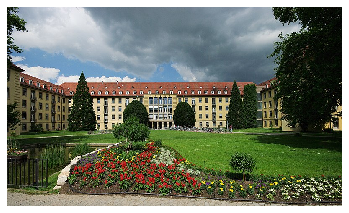

In [19]:
i = 19200
# positive images for img-based queries, image_ids range from 0 to 22265
#with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/gold_vinvl.tsv", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/gold_img.tsv", "r") as fp_img:
# negative images for img-based queries, image_ids range from 10000000 to 10340193
#with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/distractors_vinvl.tsv", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/neg_img.tsv", "r") as fp_img:
# negative images for txt-based queries, image_ids range from 20000000 to 20240699
with open("/data/yingshac/MMMHQA/WebQA_img_and_features/vinvl_features/x_distractors_vinvl.tsv", "r") as fp, open("/data/yingshac/MMMHQA/WebQA_img_and_features/imgs_base64/x_neg_img.tsv", "r") as fp_img:
    fp.seek(pred_lineidx[i])
    row = fp.readline().strip().split('\t')
    fp_img.seek(img_lineidx[i])
    _, imgid, img_base64 = fp_img.readline().strip().split('\t')
    print(row[0], imgid) # image_id in feature file and image_id in img file should agree
    pred = json.loads(row[-1])['objects']
    print("num of boxes = ", len(pred))
    im = cv2.imdecode(np.frombuffer(base64.b64decode(img_base64), dtype=np.uint8), cv2.IMREAD_COLOR)
    print("cv2 im.shape = ", im.shape)
    rects = [d["rect"] for d in pred]
    scores = [d["conf"] for d in pred]
    labels = [d["class"] for d in pred]
plt.axis('off')
plt.imshow(im[:,:,::-1])

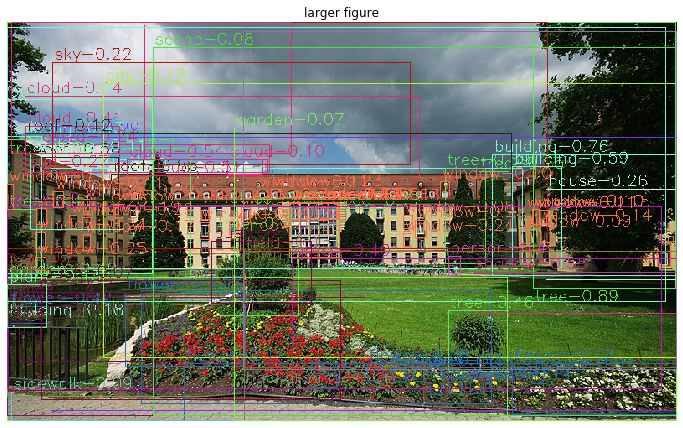

In [20]:
draw_bb(im, rects, labels, scores)
fig = plt.figure(figsize = (12,12))
ax = fig.add_subplot(111)
ax.imshow(im[:,:,::-1])
ax.set_title('larger figure')
plt.axis('off')
plt.show()

In [21]:
# VinVL predictions --> torch tensors
pred_boxes_list = []
scores_list = []
img_features_list = []
cls_features_list = []
for v in pred:
    pred_boxes_list.append(v['rect'])
    scores_list.append(v['conf'])
    img_features_list.append(np.frombuffer(base64.b64decode(v['feature']), np.float32))
    cls_features_list.append(np.frombuffer(base64.b64decode(v['scores_all']), np.float32))
pred_boxes = torch.FloatTensor(pred_boxes_list)
scores = torch.FloatTensor(scores_list)
img_features = torch.FloatTensor(img_features_list)
cls_features = torch.FloatTensor(cls_features_list)
print("box coordinates ", pred_boxes.size())
print("confidence scores ", scores.size())
print("img features ", img_features.size())
print("classification likelihoods ", cls_features.size())

box coordinates  torch.Size([100, 4])
confidence scores  torch.Size([100])
img features  torch.Size([100, 2048])
classification likelihoods  torch.Size([100, 1595])
